In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
import json
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset
from PIL import Image

from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from transformers import TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

2025-04-22 10:28:53.346448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745299733.448638    3140 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745299733.477214    3140 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745299733.709975    3140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745299733.709996    3140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745299733.709998    3140 computation_placer.cc:177] computation placer alr

In [2]:
from evaluate import load

wer_metric = load("wer")

In [3]:
encoder = "microsoft/swin-tiny-patch4-window7-224"
decoder = "sentence-transformers/all-MiniLM-L6-v2"

In [4]:
data = json.load(open('annotations/captions_train2014.json'))

In [5]:
len(data['annotations'])

414113

In [6]:
id2filename = {i['id']:i['file_name'] for i in data['images']}

In [7]:
df = pd.DataFrame(data['annotations'])

In [8]:
df['file_name'] = df['image_id'].map(id2filename)

In [9]:
df

,image_id,id,caption,file_name
0,318556,48,A very clean and well decorated empty bathroom,COCO_train2014_000000318556.jpg
1,116100,67,A panoramic view of a kitchen and all of its a...,COCO_train2014_000000116100.jpg
2,318556,126,A blue and white bathroom with butterfly theme...,COCO_train2014_000000318556.jpg
3,116100,148,A panoramic photo of a kitchen and dining room,COCO_train2014_000000116100.jpg
4,379340,173,A graffiti-ed stop sign across the street from...,COCO_train2014_000000379340.jpg
...,...,...,...,...
414108,133071,829655,a slice of bread is covered with a sour cream ...,COCO_train2014_000000133071.jpg
414109,410182,829658,A long plate hold some fries with some sliders...,COCO_train2014_000000410182.jpg
414110,180285,829665,Two women sit and pose with stuffed animals.,COCO_train2014_000000180285.jpg
414111,133071,829693,White Plate with a lot of guacamole and an ext...,COCO_train2014_000000133071.jpg


In [10]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['caption'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [12]:
image_processor = AutoImageProcessor.from_pretrained(encoder)
tokenizer = AutoTokenizer.from_pretrained(decoder)

processor = TrOCRProcessor(image_processor, tokenizer)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
train_dataset = ImageCaptioningDataset(root_dir='train2014/',
                           df=train_df,
                           processor=processor)
eval_dataset = ImageCaptioningDataset(root_dir='train2014/',
                           df=test_df,
                           processor=processor)

In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


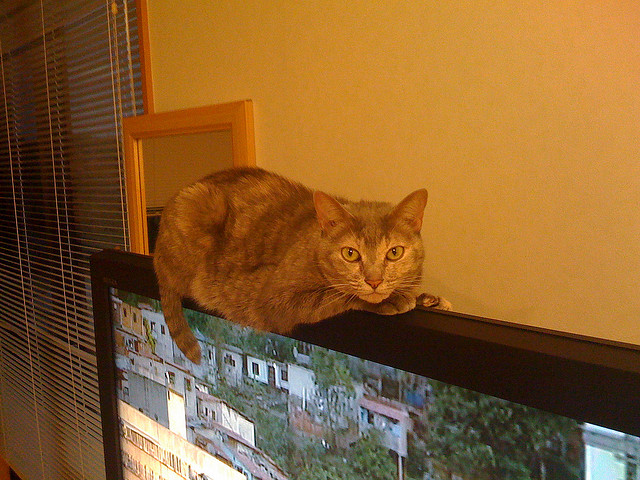

In [15]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

an unamused cat rests upon a flat screen tv


In [17]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder, decoder
)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of BertLMHeadModel were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.se

In [18]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    num_train_epochs=5,
    save_steps=100000,
    eval_steps=5000,
    dataloader_num_workers=12,
    report_to='none'
)

In [19]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    true_predictions = [f'{p} -> {l} ' for p, l in zip(pred_str, label_str) if p == l][:5]
    false_predictions = [f'{p} -> {l} ' for p, l in zip(pred_str, label_str) if p != l][:5]

    return {"wer": wer, "true_predictions": true_predictions, "false_predictions": false_predictions}

In [20]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Wer,True Predictions,False Predictions
5000,3.158700,3.146390,1.080813,[],"['a with vase flowers a and vase a and vase flowers a and vase flowers a -> a picture of a table with vases filled with daisies. ', 'a of motorcycles parked to side side side side a. people on. are in of -> a bunch of motorcycles are in a parking lot ', 'a of doughs doughs on of box on table box don -> variety of doughnuts in box ready for consumption. ', 'a motorcycle on wooden in of wooden next a.. -> a toy motorcycle that is standing up on a table. ', 'a clock a and clock a and clock a and clock -> the side of a builing with a clock on it. ']"
10000,2.799600,2.985162,1.095641,[],"['a of vase flowers a and vase a and vase a and vase flowers a and vase flowers a and -> a picture of a table with vases filled with daisies. ', 'a of motorcycles parked a of with people the. are the of are motorcycles -> a bunch of motorcycles are in a parking lot ', 'a of doughs don sitting a of doughs a of doughs -> variety of doughnuts in box ready for consumption. ', 'a motorcycle on wooden with in of doors a and. is display a -> a toy motorcycle that is standing up on a table. ', 'a clock a and clock a and clock a and clock -> the side of a builing with a clock on it. ']"
15000,2.594000,2.908266,1.105658,[],"['a of vase with flowers a and vase flowers a and vase flowers a and vase flowers a and vase -> a picture of a table with vases filled with daisies. ', 'a of people motorcycles parked a with lot people is -> a bunch of motorcycles are in a parking lot ', 'a of don sitting a of doughs a of doughs a of doughs -> variety of doughnuts in box ready for consumption. ', 'a motorcycle display a and motorcycle a and is display a -> a toy motorcycle that is standing up on a table. ', 'a clock a and clock a and clock a and -> the side of a builing with a clock on it. ']"
20000,2.669200,2.864834,1.091750,[],"['a of vase with flowers a and vase flowers a and clock a and clock -> a picture of a table with vases filled with daisies. ', 'a of people motorcycles parked a with people them people -> a bunch of motorcycles are in a parking lot ', 'a of don sitting a of don sitting a of sort -> variety of doughnuts in box ready for consumption. ', 'a motorcycle in room a with and on. is display a of -> a toy motorcycle that is standing up on a table. ', 'a clock a and clock a and wall a and wall -> the side of a builing with a clock on it. ']"
25000,2.381800,2.839227,1.074613,[],"['a of vase with flowers it a and vase flowers a and clock a and vase -> a picture of a table with vases filled with daisies. ', 'a of motorcycles parked a with people it in street are up -> a bunch of motorcycles are in a parking lot ', 'a of don sitting a of sort a of and don is -> variety of doughnuts in box ready for consumption. ', 'a motorcycle display a and motorcycle a and -> a toy motorcycle that is standing up on a table. ', 'a clock a and clock a and metal -> the side of a builing with a clock on it. ']"


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=29120, training_loss=2.7498056230145496, metrics={'train_runtime': 6567.4617, 'train_samples_per_second': 283.748, 'train_steps_per_second': 4.434, 'total_flos': 7.101512109535334e+19, 'train_loss': 2.7498056230145496, 'epoch': 5.0})

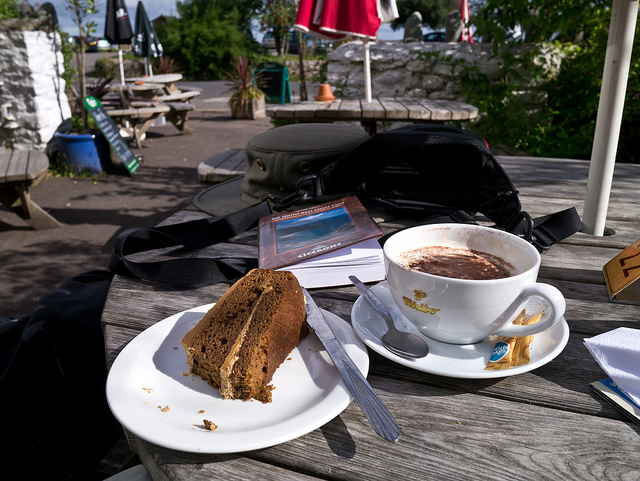

In [21]:
image = Image.open('train2014/COCO_train2014_000000000127.jpg').convert("RGB")
image

In [22]:
pixel_values = processor(image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values.to('cuda'))
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'a of of on table a of and of and plate a of of and of. cup coffee'